# Creating a Diffusion Model to Generate Target Positions

We imagine that for any natural language instruction, there is a sort of *heatmap* over visual space that corresponds reasonable end-effector positions correlating to the task. And, additionally, we imagine that this heatmap would be sufficient to control a robot's behavior. However, prior approaches that use visual planning (e.g., RVT), fail to take advantage of large-scale, pretrained internet data. This is called an *energy-based* policy, and it implicitly determines how to act.

Cheng Chi and colleagues at Columbia realized that instead of using energy-based models, we can use score matching methods (a.k.a. diffusion). However, they did not condition it to use multiple views, nor did they train on a large dataset meant for natural language inference.

I hypothesize that this is because it is difficult to repurpose existing pretrained models in a ``multi-view" transformer. Instead, I stipulate that a *single model* acting from multiple viewpoints will suffice.


## Mathematics of Diffusion

Each view generates a component of the score function. An x-view predicts $\Delta_{y, z}$, a y-view predicts $\Delta_{x, z}$, and a z-view predicts $\Delta_{x, y}$. Combined, these allow us to infer how an end-effector position should evolve. The nice thing is to realize the symmetry here: The same model for the x- and y-views can be used to predict $\Delta_{y, z}$ and $\Delta_{x, z}$ in *image space* instead of world space.

We note additionally that in order for diffusion to work, the probability distribution we wish to model must not be too far away from an i.i.d. Gaussian distribution. Think about the stochastic differential equation that guides the reverse diffusion process. If our underlying distribution has variables in the range $[-10, 10]$, but we sample noise from $x \sim \mathcal{N}(0, I)$, then we will need to make samples that are $10$ S.D. away from the underlying noise. This means it's incredibly unlikely / not well-incentivized for any diffusion model to predict these samples.

So, we scale EEF positions to the cube $[-1, 1]^3$.

I will assume that the reader is familiar with DDPM, NCSM from Yang Song's blog, and solving differential equations with Euler's method, so I will not talk about the intuition, and just write about what I am using.

We apply a denoising process. Assume that we have a signal-to-noise ratio schedule denoted by $\overline{\alpha}$. We can then calculate $\beta$ values such that $\overline{\alpha}_i = \prod_{k = 1}^{i} \alpha_k$, where $\alpha_k = 1 - \beta_k$. We can interpret $\beta_k$ as the amount of noise added at step $k$ during the forward diffusion process. This generates a set of noised samples at different noise levels $\sigma_t = \alpha_t$.

Basically, $\tilde x_t \sim \mathcal{N}(\sqrt{1 - \overline{\alpha_t}} x, \sigma_t^2) = \sqrt{1 - \overline{\alpha_t}} x + \epsilon \sigma_t$, where $\epsilon \sim \mathcal{N}(0, I)$. The true noise added to $x$ is $\epsilon$, and this is what our model is trained to predict: $p(\epsilon; \tilde x_t, \overline{\alpha_t})$. From here, we can calculate $\tilde x_{t - 1}$, which is the slightly less noisy version of $\tilde x_t$. We progressively apply this until we reach $x_0$, which is the original sample.

Instead of calculating the loss at all timesteps $t$, we tend to do Monte Carlo sampling. That is, we sample a random noise level $\sigma_t$ according to some distribution (sometimes, $\log \sigma \sim \mathcal{N}(P_{mean}, P_{std}^2)$, which promotes better predictions specifically at noise level $P_{mean}$). We also rescale loss values by some coefficient $\lambda(\sigma)$, typically $\lambda(\sigma) = \sigma^{-2}$ which makes baseline loss equal to $1$ when using MSE (inversely with variance).



## Training with Diffusion

Enough talk, let's train!


### Loading demonstration data

We use the RLBench dataset for this. We convert our demonstrations to $image \mapsto (x, y)$ pairs. We will also add language conditioning (eventually). To be honest, it would be cool to make an end-to-end language model trainer for this, for example by adding some kind of ``readout token". Maybe I can consider using LLaVA?

For example, we get a couple images of a scene, and then we reason about how to act. From there, we use LLaVA + a KV cache to diffuse the action from multiple views simultaneously.


In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['HUGGINGFACE_HUB_CACHE'] = '/scratch/' + os.environ['USER'] + '/huggingface_cache'

In [10]:
import torch
import torch.utils.data
import transformers
import pickle
from demo_to_state_action_pairs import create_torch_dataset

def get_demos(n_demos: int = 8):
    from rlbench.action_modes.action_mode import MoveArmThenGripper
    from rlbench.action_modes.arm_action_modes import JointVelocity
    from rlbench.action_modes.gripper_action_modes import Discrete
    from rlbench.environment import Environment
    from rlbench.tasks import OpenDrawer
    from rlbench.observation_config import ObservationConfig

    # from voxel_renderer import VoxelRenderer

    # Get some observations
    env = Environment(
        MoveArmThenGripper(arm_action_mode=JointVelocity(), gripper_action_mode=Discrete()),
        '/scratch/gsk6me/RLBench_Data/train',
        obs_config=ObservationConfig(),
        headless=True)
    env.launch()

    task = env.get_task(OpenDrawer)

    print("Getting demos...")
    demos = task.get_demos(n_demos, live_demos=False)

    env.shutdown()

    return demos

if not os.path.exists("demos.pkl"):
    with open("demos.pkl", "wb") as f:
        pickle.dump(get_demos(8), f)
else:
    with open("demos.pkl", "rb") as f:
        demos = pickle.load(f)

device = 'cuda'
dataset = create_torch_dataset(demos, device)


### Observations

Llava seems great for photorealistic scenarios, but not for RLBench-simulated data. Perhaps we can give Llava a description of the objects in the room to account for the photorealism gap. I wonder if Llava can locate objects that it is asked to find. It seems that in any of these non-photorealistic scenes, Llava has a very hard time describing them. I fear that this will make it hard to train models in simulation. But anyway: I will see if I can use a transformer to denoise future keypoint locations effectively.



## Model Architecture

We're getting there!

Epoch 10: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s, loss=0.0515]


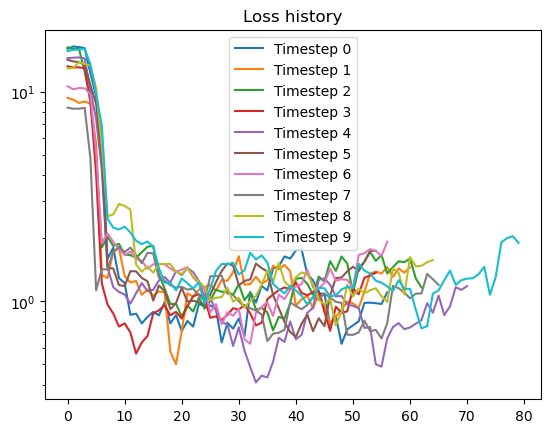

In [87]:
### V1: Regression-based. ###

from model_architectures import VisualPlanDiffuserV4, render_noisy_state

import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Load CLIP, our visual backbone. May also consider adding Segment Anything as a visual backbone, if it is fast enough.
clip = transformers.CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16")
clip = clip.to(device=device) # type: ignore
clip_processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16") # type: ignore

diffuser = VisualPlanDiffuserV4(768, clip.vision_model.config).to(device=device)

freeze_clip = True
if freeze_clip:
    diffuser.clip.requires_grad_(False)

optim = torch.optim.Adam([p for p in diffuser.parameters() if p.requires_grad], lr=1e-3)

betas = torch.linspace(0.002, 0.5, 10, device=device)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

fix_alpha_scaling = True

if fix_alpha_scaling:
    # scale so alphas_cumprod is 0 at final time
    alphas_cumprod_scaled = (alphas_cumprod - alphas_cumprod[-1]) * (alphas_cumprod[0] / (alphas_cumprod[0] - alphas_cumprod[-1]))
    # reverse-engineer the correct alphas.
    alphas_cumprod_starting = torch.tensor([1.0, *alphas_cumprod_scaled])
    alphas_cumprod_ending = torch.tensor([*alphas_cumprod_scaled, 0.0])
    alphas_scaled = alphas_cumprod_ending / alphas_cumprod_starting
    betas_scaled = 1 - alphas_scaled
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod_scaled)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod_scaled)

### Render what it looks like as a point gets progressively noisier.
# position = dataset[0][1].unsqueeze(0)
# for timestep in range(10):
#     # std.dev of noise
#     sigma = sqrt_one_minus_alphas_cumprod[timestep].unsqueeze(-1) * 112.0
#     noise = torch.randn_like(position.float())

#     # this position is in pixel space.
#     # decay the position towards the center of the image.
#     position_with_signal_decayed = 112.0 + sqrt_alphas_cumprod[timestep].unsqueeze(-1) * (position - 112.0)
#     noisy_position = position_with_signal_decayed + sigma * noise

#     rendered = render_noisy_state(noisy_position, sigma)

#     print(position, noisy_position)
#     plt.title("Timestep " + str(timestep) + " (sigma=" + str(sigma[0].item()) + ")")
#     plt.imshow(rendered[0, 0].detach().cpu().numpy(), origin='lower')
#     plt.show()

dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

loss_hist = {t: [] for t in range(10)}

# Train the diffuser.
for epoch in range(10):
    for i, (image, position) in (pbar := tqdm.tqdm(enumerate(dataloader), desc='Epoch ' + str(epoch + 1), total=len(dataloader))):
        pixel_values = clip_processor(images=image, return_tensors="pt", do_rescale=False).to(device=device).pixel_values

        timestep = torch.randint(0, 10, (position.shape[0],)).to(device)
        
        # std.dev of noise
        CENTER = 112.0
        IMG_SCALING = 224.0 / 2
        sigma = sqrt_one_minus_alphas_cumprod[timestep].unsqueeze(-1) * IMG_SCALING
        noise = torch.randn_like(position.float())

        # this position is in pixel space.
        # decay the position towards the center of the image.
        position_with_signal_decayed = CENTER + sqrt_alphas_cumprod[timestep].unsqueeze(-1) * (position - CENTER)
        noisy_position = position_with_signal_decayed + sigma * noise

        # Need to condition on timestep
        prediction = diffuser.forward(pixel_values, noisy_position, sigma)

        optim.zero_grad()
        # weight by 1/sigma^2
        error_per_sample = ((prediction - noise) ** 2).mean(dim=-1, keepdim=True)
        loss = (error_per_sample / sigma).mean()
        loss.backward()
        optim.step()

        for j in range(len(timestep)):
            loss_hist[timestep[j].item()].append(error_per_sample[j].item())

        pbar.set_postfix(loss=loss.item())

        loss.cpu()
        torch.cuda.empty_cache()

plt.title("Loss history")
for t in range(10):
    plt.plot(np.convolve(loss_hist[t], np.ones(10), mode='valid')/10, label='Timestep ' + str(t))
plt.yscale("log")
plt.legend()
plt.show()


tensor([0.2144], device='cuda:0') tensor([0.9767], device='cuda:0') tensor([[-1.2057, -1.2240]], device='cuda:0') tensor([[133.1595,  87.2955]], device='cuda:0')


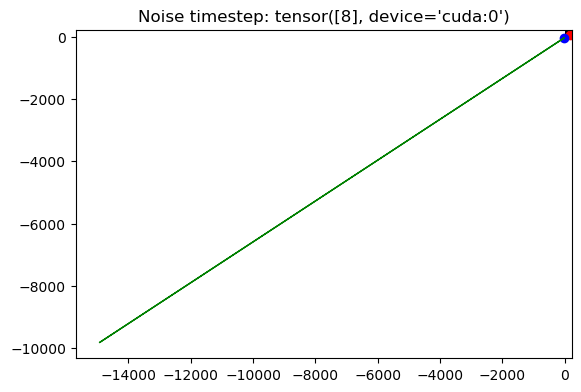

In [83]:
# Let's plot the predictions.
import matplotlib.pyplot as plt

with torch.no_grad():
    image = dataset[0][0].unsqueeze(0)
    position = dataset[0][1].unsqueeze(0)
    pixel_values = clip_processor(images=image, return_tensors="pt", do_rescale=False).to(device=device).pixel_values
    
    timestep = torch.randint(0, 10, (position.shape[0],)).to(device)
    
    # std.dev of noise
    CENTER = 112.0
    IMG_SCALING = 224.0 / 2
    sigma = sqrt_one_minus_alphas_cumprod[timestep].unsqueeze(-1) * IMG_SCALING
    noise = torch.randn_like(position.float())

    # this position is in pixel space.
    # decay the position towards the center of the image.
    position_with_signal_decayed = CENTER + sqrt_alphas_cumprod[timestep].unsqueeze(-1) * (position - CENTER)
    noisy_position = position_with_signal_decayed + sigma * noise

    # Need to condition on timestep
    prediction = diffuser.forward(pixel_values, noisy_position, sigma)
    
    print(sqrt_alphas_cumprod[timestep], sqrt_one_minus_alphas_cumprod[timestep], noise, prediction)

noisy_position_denormalized = noisy_position

# Visualize
plt.title("Noise timestep: " + str(timestep))
plt.imshow(image.cpu()[0].permute(1, 2, 0).flip(0), origin='lower')
plt.scatter(position[0, 0].item(), position[0, 1].item(), c='r')

noisy_x = noisy_position_denormalized[0, 0].item()
noisy_y = noisy_position_denormalized[0, 1].item()

plt.scatter(noisy_x, noisy_y, c='b')
# draw arrow in opposite direction of noise_pred, from noisy_position
noise_x, noise_y = prediction[0].cpu() * 112.0
plt.arrow(noisy_x, noisy_y, -noise_x, -noise_y, head_width=10, head_length=10, fc='g', ec='g')
plt.show()


### Thoughts

Does not look good at all, even when trying to overfit. Probably not great modeling approach. Will instead try a simpler approach - categorically predicting direction of target.

## V2 Categorical


Epoch 1000: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s, loss=0.617]


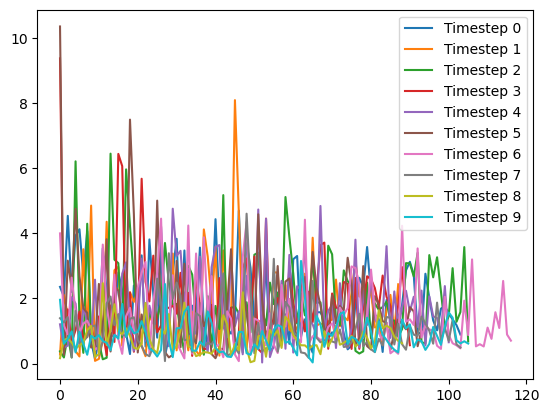

In [ ]:
from model_architectures import VisualPlanDiffuserCategorical
import tqdm
import torch.nn.functional as F

# Load CLIP, our visual backbone. May also consider adding Segment Anything as a visual backbone, if it is fast enough.
clip = transformers.CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16")
clip = clip.to(device=device)
clip_processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16") # type: ignore

diffuser = VisualPlanDiffuserCategorical(clip).to(device=device)
diffuser.clip.requires_grad_(False)
optim = torch.optim.Adam([p for p in diffuser.parameters() if p.requires_grad], lr=1e-3)

betas = torch.linspace(0.002, 0.5, 10, device=device)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

dataloader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, [0]), batch_size=32, shuffle=True)

loss_hist = {t: [] for t in range(10)}

# Train the optimizer.
for epoch in range(1000):
    for i, (image, position) in (pbar := tqdm.tqdm(enumerate(dataloader), desc='Epoch ' + str(epoch + 1), total=len(dataloader))):
        pixel_values = clip_processor(images=image, return_tensors="pt", do_rescale=False).to(device=device).pixel_values

        # Normalize position
        position_normalized = (position - 112.0) / 224.0

        timestep = torch.randint(0, 10, (position.shape[0],)).to(device)
        noise = torch.randn_like(position.float()) * 0.5

        noisy_position = sqrt_alphas_cumprod[timestep].unsqueeze(-1) * position_normalized + alphas_cumprod[timestep].unsqueeze(-1) * noise

        # Need to condition on timestep
        prediction = diffuser.forward(pixel_values, noisy_position, timestep)

        left_right_predictions = prediction[:, :2]
        left_right_labels = noisy_position[:, 0] > position_normalized[:, 0]
        up_down_predictions = prediction[:, 2:]
        up_down_labels = noisy_position[:, 1] > position_normalized[:, 1]

        optim.zero_grad()
        loss = F.cross_entropy(left_right_predictions, left_right_labels.long()) + F.cross_entropy(up_down_predictions, up_down_labels.long())
        loss.backward()
        optim.step()

        pbar.set_postfix(loss=loss.item())

        loss_hist[timestep[0].item()].append(loss.item()) # type: ignore

        loss.cpu()
        torch.cuda.empty_cache()

for t in range(10):
    plt.plot(loss_hist[t], label='Timestep ' + str(t))
plt.legend()
plt.show()


###

This has to be nonsensical.